In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

# Parameters

In [2]:
paramVariete = {"TBase":8,
                "TOpt1":26,
                "TOpt2":34,
                "TLim":44,
                "VRacLevee":1.0,
                "VRacBVP":1.0,
                "VRacPSP":1.0,
                "VRacRPR":1.0,
                "VRacMatu1":1.0,
                "VRacMatu2":1.0,
                "SDJLevee":50.0,
                "SDJBVP":400,
                "SDJRPR":400,
                "SDJMatu1":100,
                "SDJMatu2":100,
                "kcMax":0.5,
                "PFactor":0.5,
                "seuilCstrMortality":4,
                "PPSens":1,
                'txAssimBVP':1,
                'txAssimMatu1':2,
                'txAssimMatu2':3,
                }

paramITK = {"humSatMc":0, # humidité des résidus de couverture ?
            "biomIniMc":0, # Biomasse des résidues de couverture (Mulch). Unités : kg/ha
            "profRacIni":1,
            "irrigAuto":True,
            "irrigAutoTarget":0.5,
            "maxIrrig":20,
            "precision":0.1,
            "surfMc":0.0,
            "seuilEauSemis":5.0,
            "mulch":10,
            "coefMc":1,
            "nbjTestSemis":3,
            "seuilCstrMortality":10,
            }

paramTypeSol = {"ru":10,
                "epaisseurSurf":0.2,
                "stockIniSurf":5,
                "seuilRuiss":1, # qté d'eau à partir de laquelle on entre dans un régime de ruissellement (mm)
                "pourcRuiss":0.5, # pourcentge de pluie qui ruisselle passé le seuil seuilRuiss (pct décimal)
                "stockIniProf":0.5,
                "epaisseurProf" : 1,
                }

# ruRac = paramTypeSol["ru"] * paramITK["profRacIni"] / 1000 # alt name rRac
# ruSurf = paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]

# Initialization of variables

In [3]:
# getting weather data
weatherdata = NASAPowerWeatherDataProvider(longitude=5, latitude=52)
print(weatherdata)
df = pd.DataFrame(weatherdata.export())
df = df[(df["DAY"]>=datetime.date(2020,1,1)) & (df["DAY"]<=datetime.date(2020,12,31))]
df.head()

df["DOY"] = df.apply(lambda x: x["DAY"].timetuple().tm_yday, axis=1)

# initializing variables
grid_width = 1
grid_height = 1

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:    3.5
Latitude:  52.000
Longitude:  5.000
Data available for 1984-01-01 - 2022-06-21
Number of missing days: 1



In [4]:
stockSurfaceInit = 10

def init():
        
        data = {
        "ddj": np.zeros(shape=(grid_width, grid_height, len(df))),
        "sdj": np.zeros(shape=(grid_width, grid_height, len(df))), # Somme de degrés.jours depuis la germination. Unité : °C.d
        
        
        "rain": df["RAIN"].values.reshape(grid_width, grid_height, len(df["RAIN"].values)), # pluviométrie (mm)
        "tpMoy": df["TEMP"].values.reshape(grid_width, grid_height, len(df["TEMP"].values)),
        "numPhase": np.zeros(shape=(grid_width, grid_height, len(df))),
        "ruRac": np.full((grid_width, grid_height, len(df)), paramITK["profRacIni"] / 1000 * paramTypeSol["ru"]),
        "ruSurf": np.full((grid_width, grid_height, len(df)),paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]),
        "biomMc": np.full((grid_width, grid_height, len(df)),paramITK["biomIniMc"]), # Biomasse des résidues de couverture (Mulch). Unités : kg/ha
        "nbJourCompte": np.zeros(shape=(grid_width, grid_height, len(df))),
        "stockSurface" : np.full((grid_width, grid_height, len(df)),stockSurfaceInit), # Stock d'eau initial dans l'horizon de surface. Unité : mm
        "irrig" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "hum" : np.zeros(shape=(grid_width, grid_height, len(df))), # Quantité d'eau maximum jusqu'au front d'humectation. Unités : mm
        "vRac" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "changePhase" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "stockRac" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "correctedIrrigation" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "irrigTotDay" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "ruIrr" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "stockIrr" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "eauDispo" : np.zeros(shape=(grid_width, grid_height, len(df))), # Quantité journalière d'eau infiltrée dans le sol (moins le ruissellement). Unités : mm 
        "stockMc" : np.zeros(shape=(grid_width, grid_height, len(df))), # Stock d'eau dans les résidus (mulch). Unités : mm
        "lr" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "eauCaptee" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "cstr" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "ru" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "dayVrac" : np.zeros(shape=(grid_width, grid_height, len(df))),	
        "deltaRur" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "profRu" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "stRuMax" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "stRuSurfPrec" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "eauTranspi" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "stockTotal" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "dr" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "stockSurfaceTemp" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "feswTemp" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "ltrTemp" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "bioMc" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "kceTemp" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "etp": np.full((grid_width, grid_height, len(df)),df["ET0"].values),
        "evalPotTemp": np.full((grid_width, grid_height, len(df)),df["ET0"].values),
        "stockMcTemp": np.zeros(shape=(grid_width, grid_height, len(df))),
        "FEMcW": np.zeros(shape=(grid_width, grid_height, len(df))),
        "evapTemp": np.zeros(shape=(grid_width, grid_height, len(df))),
        "ftsw": np.zeros(shape=(grid_width, grid_height, len(df))),
        "ltr": np.zeros(shape=(grid_width, grid_height, len(df))),
        "kcp": np.zeros(shape=(grid_width, grid_height, len(df))),
        "trPot": np.zeros(shape=(grid_width, grid_height, len(df))),
        "pFact": np.zeros(shape=(grid_width, grid_height, len(df))),
        "tr": np.zeros(shape=(grid_width, grid_height, len(df))),
        "evap": np.zeros(shape=(grid_width, grid_height, len(df))),
        "trSurf": np.zeros(shape=(grid_width, grid_height, len(df))),
        "consoRur": np.zeros(shape=(grid_width, grid_height, len(df))),
        "seuilTempPhaseSuivante": np.zeros(shape=(grid_width, grid_height, len(df))),
        "phasePhotoper": np.zeros(shape=(grid_width, grid_height, len(df))),
        "seuilTempPhasePrec": np.zeros(shape=(grid_width, grid_height, len(df))),
        "sommeDegresJourPhasePrec": np.zeros(shape=(grid_width, grid_height, len(df))),
        "nbjStress": np.zeros(shape=(grid_width, grid_height, len(df))),
        "dateRecolte": np.zeros(shape=(grid_width, grid_height, len(df))),
        "dateFin": np.zeros(shape=(grid_width, grid_height, len(df))),
        "TMoyMatu": np.zeros(shape=(grid_width, grid_height, len(df))),
        "jourFinPP": np.zeros(shape=(grid_width, grid_height, len(df))),
        "deltaBiomasseAerienne": np.zeros(shape=(grid_width, grid_height, len(df))),
        "profRu": np.full((grid_width, grid_height, len(df)),paramTypeSol["epaisseurSurf"] + paramTypeSol["epaisseurProf"])
        

        }
        return data

In [5]:
def initialisationSol(data, paramTypeSol):
	"""
 		//remplacé par 
 	   	let  truSurf= paramTypeSol.epaisseurSurf / 1000 * paramTypeSol.ru
 	   	ruSurf = truSurf
		ru = paramTypeSol.ru
		let rRac= paramTypeSol.ru * paramITK.profRacIni / 1000
		ruRac = rRac
		//fin remplacé par 
	    //ruSurf= paramTypeSol.EpaisseurSurf",solNames,  typesSol) / 1000 * paramTypeSol.Ru",solNames,  typesSol)
		//modif 10/06/2015  plus de pft
	    //let pfT = paramTypeSol.EpaisseurSurf",solNames,  typesSol) * paramTypeSol.HumPF",solNames,  typesSol)
	    //pfTranspi = pfT
	    //let sT = paramTypeSol.StockIniSurf",solNames,  typesSol) - pfT/2 + paramTypeSol.StockIniProf",solNames,  typesSol)
	    let sT = paramTypeSol.stockIniSurf + paramTypeSol.stockIniProf
	    stockTotal = sT
	    profRu = paramTypeSol.epaisseurSurf  + paramTypeSol.epaisseurProf
		//modif 10/06/2015 hum mis a au moins ruSurf
		let tHum =  Max(truSurf,rRac)	 
		hum = Max (sT, tHum)
		}
	} // fin initialisationSol 
	"""
	# ruSurf (truSurf) : Reserve utile de l'horizon de surface. Unités :mm
	# data["ruSurf"] =  paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]

	# ruRac (rRac) : Capacité maximum d'eau rapporté à la profondeur racinaire en cours. Unité : mm
	# data["ruRac"] =  np.full((grid_width, grid_height, len(df)), paramITK["profRacIni"] / 1000 * paramTypeSol["ru"])

	# stockTotal (sT) : Stock d'eau total sur l'ensemble des réservoir. Unités : mm
	data["stockTotal"] = paramTypeSol["stockIniSurf"] + paramTypeSol["stockIniProf"] 

	# Profondeur maximale de sol. Unités : mm
	# data["profRu"] = paramTypeSol["epaisseurSurf"] + paramTypeSol["epaisseurProf"]

	# valeur maximale entre la réserve utile du réservoir de surface et la réserve utile racinaire (mm)
	data["tHum"] = np.maximum(data["ruSurf"], data["ruRac"])

	# Quantité d'eau maximum jusqu'au front d'humectation. Unités : mm
	data["hum"] = np.maximum(data["stockTotal"], data["tHum"])

	return data

# Bilan phéno

## Fonctions

In [6]:
def EvalDegresJourSarrahV3(j, data, paramVariete):
    

    data["ddj"][:,:,j] = np.where(
                data["tpMoy"][:,:,j] <= paramVariete["TOpt2"],
                np.maximum(np.minimum(paramVariete["TOpt1"], data["tpMoy"][:,:,j]), paramVariete["TBase"]) - paramVariete["TBase"],
                (paramVariete["TOpt1"] - paramVariete["TBase"]) * (1 - ((np.minimum(paramVariete["TLim"], data["tpMoy"][:,:,j]) - paramVariete["TOpt2"])
                    / (paramVariete["TLim"] - paramVariete["TOpt2"]))),
                )  

    data["sdj"][:,:,j] = np.where(data["numPhase"][:,:,j] >= 1,
                                data["sdj"][:,:,j] + data["ddj"][:,:,j],
                                0,
                                )

    return data


In [7]:
def EvalPhenoSarrahV3(j, data, paramITK):

    #EvalPhenoSarrahV3

    # test de germination
    data["changePhase"][:,:,j] = np.where(
                                    # test 1
                                    data["numPhase"][:,:,j]==0,
                                    # if 1 true
                                    np.where(
                                        data["stockSurface"][:,:,j] - data["ruSurf"][:,:,j]/10 >= paramITK["seuilEauSemis"],
                                        1,
                                        0,
                                    ),
                                    # if 1 false                                    
                                    np.where(
                                        # test 2
                                        (data["numPhase"][:,:,j]==2) & (data["sdj"][:,:,j]>= data["seuilTempPhaseSuivante"][:,:,j]),
                                        # if 2 true
                                        1,
                                        # if 2 false
                                        np.where(
                                            # test 3
                                            data["numPhase"][:,:,j] != 3,
                                            # if 3 true
                                            np.where(
                                                # test 4
                                                data["sdj"][:,:,j] >= data["seuilTempPhaseSuivante"][:,:,j],
                                                # if 4 true
                                                1,
                                                # if 4 false
                                                0,
                                            ),
                                            # if 3 false
                                            np.where(
                                                # test 5
                                                data["phasePhotoper"][:,:,j] == 0,
                                                # if 5 true
                                                1,
                                                # if 5 false
                                                0,
                                            ),
                                        ),
                                    ),
                                )

    
    data["seuilTempPhaseSuivante"][:,:,j] = np.where(
                                                (data["numPhase"][:,:,j]==0) & (data["stockSurface"][:,:,j] - data["ruSurf"][:,:,j]/10 >= paramITK["seuilEauSemis"]),
                                                paramVariete["SDJLevee"],
                                                data["seuilTempPhaseSuivante"][:,:,j],
                                            )

    data["sommeDegresJourPhasePrec"][:,:,j] = np.where(
                                                    data["changePhase"][:,:,j] == 1,
                                                    data["seuilTempPhasePrec"][:,:,j],
                                                    data["sommeDegresJourPhasePrec"][:,:,j],
                                                )

    data["numPhase"][:,:,j] = np.where(data["changePhase"][:,:,j] == 1,
                                                        data["numPhase"][:,:,j] + 1 ,
                                                        data["numPhase"][:,:,j],
                                                        )

    data["seuilTempPhaseSuivante"][:,:,j] = np.where(
                                                (data["changePhase"][:,:,j]==1),
                                                np.where(
                                                    (data["numPhase"][:,:,j]==1),
                                                    paramVariete["SDJLevee"],
                                                    np.where(
                                                        data["numPhase"][:,:,j]==2,
                                                        data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJBVP"],
                                                        np.where(
                                                            data["numPhase"][:,:,j]==4,
                                                            data["sdj"][:,:,j] + paramVariete["SDJRPR"],
                                                            np.where(
                                                                data["numPhase"][:,:,j]==5,
                                                                data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJMatu1"],
                                                                np.where(
                                                                    data["numPhase"][:,:,j]==6,
                                                                    data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJMatu2"],
                                                                    data["seuilTempPhaseSuivante"][:,:,j],
                                                                ),
                                                            ),
                                                        ),
                                                    ),
                                                ),
                                                data["seuilTempPhaseSuivante"][:,:,j],
                                            )
                                                


    data["phasePhotoper"][:,:,j] = np.where(
                                            (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==3),
                                            1,
                                            data["phasePhotoper"][:,:,j],
                                            )           

    data["nbjStress"][:,:,j] = np.where(
                                            (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==7),
                                            paramVariete["seuilCstrMortality"] + 1,
                                            data["nbjStress"][:,:,j],
                                            )

    data["dateRecolte"][:,:,j] = np.where(
                                            (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==7),
                                            j,
                                            data["dateRecolte"][:,:,j],
                                            )
    
    return data                            

In [8]:
def PPTmoySarrahV3(j, data, paramVariete):

    data["jourFinPP"][:,:,j] = np.where(
                                    data["phasePhotoper"][:,:,j] == 1,
                                    data["dateFin"][:,:,j] - ((paramVariete["SDJMatu1"] + paramVariete["SDJMatu2"] + paramVariete["SDJRPR"]) / (data["TMoyMatu"][:,:,j] - paramVariete["TBase"])),
                                    data["jourFinPP"][:,:,j],
                                    )

    data["jourFinPP"][:,:,j] = np.where(
                                    (data["phasePhotoper"][:,:,j] == 1) & (data["jourFinPP"][:,:,j]<0),
                                    365 + data["jourFinPP"][:,:,j],
                                    data["jourFinPP"][:,:,j],
                                    )

    data["phasePhotoper"][:,:,j] = np.where(
                                    (data["phasePhotoper"][:,:,j] == 1),
                                    np.where(
                                        j > data["jourFinPP"][:,:,j],
                                        0,
                                        data["phasePhotoper"][:,:,j],
                                    ) if paramVariete["PPSens"] <= 1 else 0,
                                    data["phasePhotoper"][:,:,j],
                                    )

    data["changePhase"][:,:,j] = np.where(
                                    (data["phasePhotoper"][:,:,j] == 1),
                                    np.where(
                                        j > data["jourFinPP"][:,:,j],
                                        1,
                                        data["changePhase"][:,:,j],
                                    ) if paramVariete["PPSens"] <= 1 else 0,
                                    data["changePhase"][:,:,j],
                                    )

    return data

In [9]:
def MortaliteSarraV3(dat, paramITK):

    data['nbJourCompte'][:,:,j] = np.where(
                                        data["numPhase"][:,:,j] == 2,
                                        data['nbJourCompte'][:,:,j] + 1,
                                        data['nbJourCompte'][:,:,j],
                                        )

    data["nbjStress"][:,:,j] = np.where(
                                        (data["numPhase"][:,:,j] == 2) & (data["nbJourCompte"][:,:,j] < paramITK["nbjTestSemis"]) & (data["deltaBiomasseAerienne"][:,:,j] < 0),
                                        data["nbjStress"][:,:,j] + 1,
                                        data["nbjStress"][:,:,j],                           
                                        )

    data["nbJourCompte"][:,:,j] = np.where(
                                        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] < paramITK["seuilCstrMortality"]),
                                        0,
                                        data["nbJourCompte"][:,:,j],
                                        )

    data["numPhase"][:,:,j] = np.where(
                                        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] < paramITK["seuilCstrMortality"]),
                                        0,
                                        data["numPhase"][:,:,j],
                                        )

    data["ruRac"][:,:,j] = np.where(
                                        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] < paramITK["seuilCstrMortality"]),
                                        0,
                                        data["ruRac"][:,:,j],
                                        )

    data["nbjStress"][:,:,j] = np.where(
                                        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] < paramITK["seuilCstrMortality"]),
                                        0,
                                        data["nbjStress"][:,:,j],
                                        )

    return data
                                    


## Bilan

In [10]:
def bilanPheno(j, data, paramITK, paramTypeSol, paramVariete):
	
    """
    data['numPhase'][:,:,j] = np.where(
                                    data['numPhase'][:,:,j]==7,
                                    0,
                                    data['numPhase'][:,:,j],
                                    )

    data['ruRac'][:,:,j] = np.where(
                                    data['numPhase'][:,:,j]==7,
                                    0,
                                    data['ruRac'][:,:,j],
                                    )

    data['nbJourCompte'][:,:,j] = np.where(
                                    data['numPhase'][:,:,j]==7,
                                    0,
                                    data['nbJourCompte'][:,:,j],
                                    )
    """
    
    # if (j >= (dateDebut + varDateSemis) && nbjStress < paramVariete.seuilCstrMortality ){
	

    data = EvalDegresJourSarrahV3(j, data, paramVariete)
    data = EvalPhenoSarrahV3(j, data, paramITK)
    #data = PPTmoySarrahV3(data, paramVariete)
    #data = MortaliteSarraV3(data, paramITK)

    # bilan carbo

    # else 

    # bilan hydro

    return data


## Run partiel 

In [11]:
data = init()
for j in tqdm(range(len(df))):
    data = bilanPheno(j, data, paramITK, paramTypeSol, paramVariete)

100%|██████████| 366/366 [00:00<00:00, 1130.32it/s]


In [12]:
data["changePhase"]

array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [224]:
data["numPhase"]

array([[[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
          10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
          20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
          30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
          40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,
          50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
          60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
          70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
          80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
          90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
         100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
         110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
         120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
         130., 131., 132., 133., 134., 135., 136., 137., 138., 139.,
         140., 141., 142., 143., 1

In [221]:
data["seuilTempPhaseSuivante"]

array([[[ 50.,  50., 400.,   0., 400., 100., 100.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,  

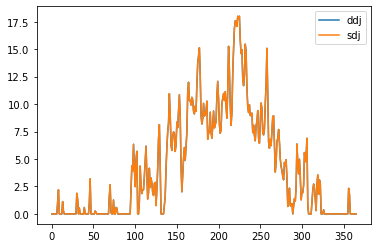

In [222]:
# plt.plot(data["eauDispo"][0,0,:], label="eau disponible")
plt.plot(data["ddj"][0,0,:], label="ddj")
plt.plot(data["sdj"][0,0,:], label="sdj")
plt.legend()
plt.show()

# Bilan hydro

In [7]:
    def EvalIrrigPhase(data, paramITK):
        # eauDispo : Quantité journalière d'eau infiltrée dans le sol (moins le ruissellement). Unités : mm 
        
        if paramITK["irrigAuto"]==True : # && (numphase > 0) && (numphase < 6) )
            data["stockIrr"][:,:,j] = np.where((data["ruRac"][:,:,j] < data["ruSurf"][:,:,j]),
                                        data["stockSurface"][:,:,j],
                                        data["stockRac"][:,:,j],
                                        )

            data["ruIrr"][:,:,j] = np.where((data["ruRac"][:,:,j] < data["ruSurf"][:,:,j]),
                                        data["ruSurf"][:,:,j],
                                        data["ruRac"][:,:,j],
                                        )
            
            data["irrigTotDay"][:,:,j] = np.where((data["stockIrr"][:,:,j]/data["ruIrr"][:,:,j] < paramITK["irrigAutoTarget"]),
                                            np.minimum(np.maximum(0, (data["ruIrr"][:,:,j] - data["stockIrr"][:,:,j]) * 0.9 - data["correctedIrrigation"][:,:,j]), paramITK["maxIrrig"]),
                                            data["irrigTotDay"][:,:,j],
                                            )
            # irrigTotDay = round(irrigTotDay /  paramITK.precision) *  paramITK.precision

        data["irrigTotDay"][:,:,j] = data["correctedIrrigation"][:,:,j] + data["irrigTotDay"][:,:,j]		
        
        data["eauDispo"][:,:,j] = data["rain"][:,:,j] + data["irrigTotDay"][:,:,j]

        return data

In [8]:

def rempliMc_evalRunOff(data, paramITK, paramTypeSol):

    # rempliMc
    # humSatMc ???
    # biomMc : biomasse mulch, kg/ha
    # stockMc : Stock d'eau dans les résidus (mulch). Unités : mm
    # eauDispo : Quantité journalière d'eau infiltrée dans le sol (moins le ruissellement). Unités : mm 
    # surfMc : ???
    
    # on calcule la quantité maximale d'eau stockable par le mulch en prenant le minimum entre :
    # - l'utilisation d'une fonction de la quantité d'eau disponible qui tend vers eauDispo quand surfMc ou biomMc augmentent
    # - la différence entre la quantité d'eau au point de saturation et le stock d'eau connu du mulch
    # on calcule ensuite l'eau disponible en retranchant l'eau captée si sa valeur est supérieure à 0
    # on incrémente ensuite la quantité d'eau dans le mulch par la quantité d'eau captée
    data["eauCaptee"][:,:,j] = np.minimum(
                                    data["eauDispo"][:,:,j] * (1-np.exp(-paramITK["surfMc"] * data["biomMc"][:,:,j]/1000)),
                                    (paramITK["humSatMc"] * data["biomMc"][:,:,j]/ 10000) - data["stockMc"][:,:,j],
                                    )
    data["eauDispo"][:,:,j] =  np.maximum(data["eauDispo"][:,:,j] - data["eauCaptee"][:,:,j], 0)
    data["stockMc"][:,:,j] = data["stockMc"][:,:,j] + data["eauCaptee"][:,:,j]
    
    # EvalRunOff
    # rain : pluviométrie (mm)
    # seuilRuiss : Seuil pluie, calcul du ruissellement (cf PourcRuiss) (mm)
    # pourcRuiss : (pct décimal)
    data["lr"][:,:,j] = np.where(data["rain"][:,:,j] > paramTypeSol["seuilRuiss"],
                            (data["eauDispo"][:,:,j]  - paramTypeSol["seuilRuiss"]) *  paramTypeSol["pourcRuiss"],
                            data["lr"][:,:,j],
                            )
    data["eauDispo"][:,:,j] = data["eauDispo"][:,:,j] - data["lr"][:,:,j]
    return data

In [9]:

def EvolRurCstr(data, paramITK):
    data["dayVrac"][:,:,j] = np.where((data["numPhase"][:,:,j]>0) & np.invert((data["changePhase"][:,:,j]==True) & (data["numPhase"][:,:,j]==1)) & (data["ruRac"][:,:,j]>data["ruSurf"][:,:,j]),
                                        (data["vRac"][:,:,j] * np.minimum(data["cstr"][:,:,j] + 0.3, 1.0)) / 1000 * data["ru"][:,:,j],
                                        data["dayVrac"][:,:,j],
                                        )
    
    data["deltaRur"][:,:,j] = np.where((data["numPhase"][:,:,j]>0) & np.invert((data["changePhase"][:,:,j]==True) & (data["numPhase"][:,:,j]==1)) & (data["ruRac"][:,:,j]>data["ruSurf"][:,:,j]),
                                np.where((data["hum"][:,:,j]-data["ruRac"][:,:,j])<data["dayVrac"][:,:,j],
                                    data["hum"][:,:,j] - data["ruRac"][:,:,j],
                                    data["dayVrac"][:,:,j],
                                ),
                                data["vRac"][:,:,j]/1000*data["ru"][:,:,j],
                                )
    
    data["ruRac"][:,:,j] = np.where((data["numPhase"][:,:,j]>0) & (data["changePhase"][:,:,j]==True) & (data["numPhase"][:,:,j]==1),
                                paramITK["profRacIni"]/1000*data["ru"][:,:,j],
                                data["ruRac"][:,:,j] + data["deltaRur"][:,:,j],
                                )
    return data

In [10]:
def rempliRes(data):
    data["stRuMax"][:,:,j] = data["ru"][:,:,j] * data["profRu"][:,:,j] / 1000
    data["stockSurface"][:,:,j] = np.minimum(data["stockSurface"][:,:,j] + data["eauDispo"][:,:,j], data["ruSurf"][:,:,j] * 1.1)

    data["eauTranspi"][:,:,j] = np.where(data["stRuSurfPrec"][:,:,j] < data["ruSurf"][:,:,j]/10,
                                            np.maximum(0, data["eauDispo"][:,:,j] - (data["ruSurf"][:,:,j]/10 - data["stRuSurfPrec"][:,:,j])),
                                            data["eauDispo"][:,:,j],
                                            )

    data["stockTotal"][:,:,j] = data["stockTotal"][:,:,j] + data["eauTranspi"][:,:,j]

    data["dr"][:,:,j] = np.where(data["stockTotal"][:,:,j] > data["stRuMax"][:,:,j],
                                    data["stockTotal"][:,:,j] - data["stRuMax"][:,:,j],
                                    data["dr"][:,:,j] * 0,
                                    )

    data["stockTotal"][:,:,j] = np.where(data["stockTotal"][:,:,j] > data["stRuMax"][:,:,j],
                                        data["stRuMax"][:,:,j],
                                        data["stockTotal"][:,:,j],
                                        )

    data["hum"][:,:,j] = np.maximum(data["hum"][:,:,j], data["stockTotal"][:,:,j])

    data["stockRac"][:,:,j] = np.minimum(np.minimum(data["stockTotal"][:,:,j] + data["eauTranspi"][:,:,j], data["ruRac"][:,:,j]), data["stockTotal"][:,:,j])
    return data

In [11]:
def Evaporation(data, paramITK):
    # evalFESW
    data["feswTemp"][:,:,j] = data["stockSurfaceTemp"][:,:,j] / (data["ruSurf"][:,:,j] * 1.1)

    # evalKceMc
    data["kceTemp"][:,:,j] = paramITK["mulch"] / 100 * data["ltrTemp"][:,:,j] * np.exp(-paramITK["coefMc"] * paramITK["surfMc"] * data["bioMc"][:,:,j]/1000)

    # demandeSol
    data["evalPotTemp"][:,:,j] = data["etp"][:,:,j] * data["kceTemp"][:,:,j]

    # evapMc
    data["FEMcW"][:,:,j] = (paramITK["humSatMc"] * data["bioMc"][:,:,j] * 0.001) / data["stockMcTemp"][:,:,j]
    data["stockMcTemp"][:,:,j] = np.where(data["stockMcTemp"][:,:,j] > 0,
                                            np.maximum(0, data["stockMcTemp"][:,:,j] - data["ltrTemp"][:,:,j] * data["etp"][:,:,j] * data["FEMcW"][:,:,j]**2),
                                            data["stockMcTemp"][:,:,j],
                                            )

    # evapRuSurf
    data["evapTemp"][:,:,j] = np.minimum(data["evalPotTemp"][:,:,j] * data["feswTemp"][:,:,j]**2, data["stockSurfaceTemp"][:,:,j])

    return data

In [12]:
def Transpiration(data, paramVariete):

    #transpiration
    # EvalFTSW
    data["ftsw"][:,:,j] = np.where(data["ruRac"][:,:,j] > 0,
                                    data["stockRac"][:,:,j] / data["ruRac"][:,:,j],
                                    data["ftsw"][:,:,j]*0,
                                    )

    # EvolKcpKcIni
    data["kcp"][:,:,j] = np.maximum(0.3, paramVariete["kcMax"] * (1 - data["ltr"][:,:,j]))

    #demandePlante
    data["trPot"][:,:,j] = data["kcp"][:,:,j] * data["etp"][:,:,j]

    data["pFact"][:,:,j] = paramVariete["PFactor"] + 0.04 * (5 - np.maximum(data["kcp"][:,:,j], 1) * data["etp"][:,:,j])
    data["pFact"][:,:,j] = np.minimum(np.maximum(0.1, data["pFact"][:,:,j]), 0.8)

    data["cstr"][:,:,j] = np.minimum((data["ftsw"][:,:,j] / (1 - data["pFact"][:,:,j])), 1)
    data["cstr"][:,:,j] = np.maximum(0, data["cstr"][:,:,j])

    # evalTranspi
    data["tr"][:,:,j] = data["trPot"][:,:,j] * data["cstr"][:,:,j]

    return data


In [13]:
def ConsoResSep(data):

    # consoResSep
    data["stockSurface"][:,:,j] = np.maximum(data["stockSurface"][:,:,j] - data["evap"][:,:,j], 10)

    data["consoRur"][:,:,j] = np.where(data["evap"][:,:,j] > data["trSurf"][:,:,j],
                                        data["trSurf"][:,:,j],
                                        data["evap"][:,:,j],
                                        )

    data["stockTotal"][:,:,j] = np.maximum(0, data["stockTotal"][:,:,j] - data["consoRur"][:,:,j])

    data["consoRur"][:,:,j] = np.where(data["ruRac"][:,:,j] < data["ruSurf"][:,:,j],
                                        data["evap"][:,:,j] * data["stockRac"][:,:,j] / data["ruSurf"][:,:,j],
                                        data["consoRur"][:,:,j],
                                        )

    data["stockRac"][:,:,j] = np.maximum(0, data["stockRac"][:,:,j] - data["consoRur"][:,:,j])

    data["tr"][:,:,j] = np.where(data["tr"][:,:,j] > data["stockRac"][:,:,j],
                                    np.maximum(data["stockRac"][:,:,j] - data["tr"][:,:,j], 0),
                                    data["tr"][:,:,j],
                                    )

    data["stockSurface"][:,:,j] = np.where(data["stockRac"][:,:,j]>0,
                                            np.maximum(data["stockSurface"][:,:,j] - (data["tr"][:,:,j] * np.minimum(data["trSurf"][:,:,j]/data["stockRac"][:,:,j], 1)), 0),
                                            data["stockSurface"][:,:,j],
                                            )
    
    data["stockRac"][:,:,j] = np.maximum(0, data["stockRac"][:,:,j] - data["tr"][:,:,j])
    data["stockTotal"][:,:,j] = np.maximum(0, data["stockTotal"][:,:,j] - data["tr"][:,:,j])

    return data

# bilan carbo

In [18]:
def EvalVitesseRacSarraV3(data, paramVariete):
    # EvalVitesseRacSarraV3
    data["vRac"][:,:,j] = np.where(
                                data["numPhase"][:,:,j] == 1,
                                paramVariete['VRacLevee'],
                                np.where(
                                    data["numPhase"][:,:,j] == 2,
                                    paramVariete['VRacBVP'],
                                    np.where(
                                        data["numPhase"][:,:,j] == 3,
                                        paramVariete['VRacPSP'],
                                        np.where(
                                            data["numPhase"][:,:,j] == 4,
                                            paramVariete['VRacRPR'],
                                            np.where(
                                                data["numPhase"][:,:,j] == 5,
                                                paramVariete['VRacMatu1'],
                                                np.where(
                                                    data["numPhase"][:,:,j] == 6,
                                                    paramVariete['VRacMatu2'],
                                                    0,
                                                    )
                                                )
                                            )
                                        )
                                    )
                                )

    return data

In [19]:
def EvalConversion(data, paramVariete):
    # EvalConversion
    data["KAssim"][:,:,j] = np.where(
                                data["numPhase"][:,:,j] == 2,
                                1,
                                np.where(
                                    data["numPhase"][:,:,j] == 3,
                                    paramVariete['txAssimBVP'],
                                    np.where(
                                        data["numPhase"][:,:,j] == 4,
                                        paramVariete['txAssimBVP'],
                                        np.where(
                                            data["numPhase"][:,:,j] == 5,
                                            paramVariete["txAssimBVP"] + (data['sdj'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]) * (paramVariete['txAssimMatu1'] -  paramVariete['txAssimBVP']) / (data['seuilTempPhaseSuivante'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]),
                                            np.where(
                                                data["numPhase"][:,:,j] == 6,
                                                paramVariete["txAssimMatu1"] + (data["sdj"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j]) * ( paramVariete["txAssimMatu2"] - paramVariete["txAssimMatu1"]) / (data["seuilTempPhaseSuivante"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j],
                                                0,
                                                    )
                                                )
                                            )
                                        )
                                    )
                                )

    return data

# bilans

In [20]:
def bilanHydro(data, paramITK, paramTypeSol, paramVariete):
    data = EvalIrrigPhase(data, paramITK)
    data = rempliMc_evalRunOff(data, paramITK, paramTypeSol)
    data = EvolRurCstr(data, paramITK)
    data = rempliRes(data)
    data = Evaporation(data, paramITK)
    data = Transpiration(data, paramVariete)
    data = ConsoResSep(data)
    return data

In [22]:
def bilanCarbo(data, paramITK, paramTypeSol, paramVariete):
    data = EvalVitesseRacSarraV3(data, paramVariete)
    data = EvalConversion(data, paramVariete)

# run

In [33]:
for j in tqdm(range(len(df))):
    # print("jour",j)

    bilanPheno(data, paramITK, paramTypeSol, paramVariete)
    #bilanCarbo(data, paramITK, paramTypeSol, paramVariete)
    #bilanHydro(data, paramITK, paramTypeSol, paramVariete)

100%|██████████| 366/366 [00:00<00:00, 1198.86it/s]


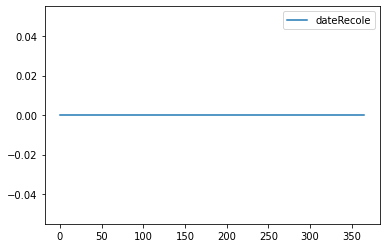

In [ ]:
# plt.plot(data["eauDispo"][0,0,:], label="eau disponible")
plt.plot(data["nbjStress"][0,0,:], label="dateRecole")

plt.legend()
plt.show()

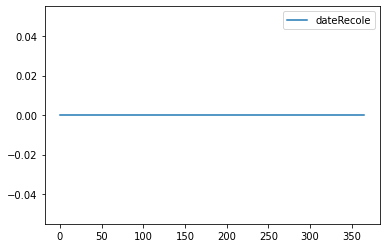

In [ ]:
# plt.plot(data["eauDispo"][0,0,:], label="eau disponible")
plt.plot(data["dateRecolte"][0,0,:], label="dateRecole")

plt.legend()
plt.show()

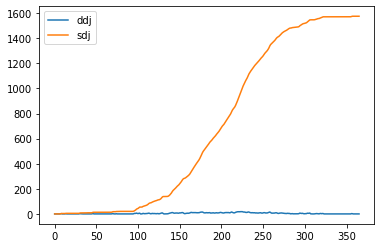

In [ ]:
# plt.plot(data["eauDispo"][0,0,:], label="eau disponible")
plt.plot(data["ddj"][0,0,:], label="ddj")
plt.plot(data["sdj"][0,0,:], label="sdj")
plt.legend()
plt.show()

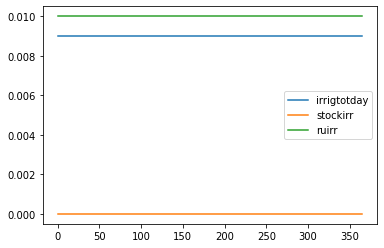

In [ ]:
# plt.plot(data["eauDispo"][0,0,:], label="eau disponible")
plt.plot(data["irrigTotDay"][0,0,:], label="irrigtotday")
plt.plot(data["stockIrr"][0,0,:], label="stockirr")
plt.plot(data["ruIrr"][0,0,:], label="ruirr")
plt.legend()
plt.show()

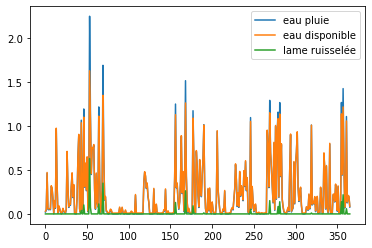

In [ ]:
plt.plot(data["rain"][0,0,:], label="eau pluie")
plt.plot(data["eauDispo"][0,0,:], label="eau disponible")
plt.plot(data["lr"][0,0,:], label="lame ruisselée")
plt.legend()
plt.show()

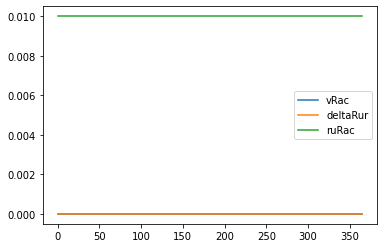

In [ ]:
plt.plot(data["vRac"][0,0,:], label="vRac")
plt.plot(data["deltaRur"][0,0,:], label="deltaRur")
plt.plot(data["ruRac"][0,0,:], label="ruRac")
plt.legend()
plt.show()

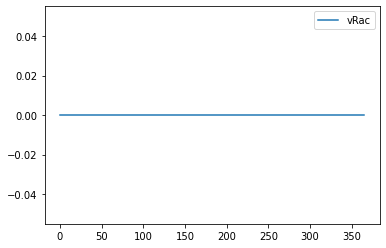

In [ ]:
plt.plot(data["stockRac"][0,0,:], label="vRac")
plt.legend()
plt.show()

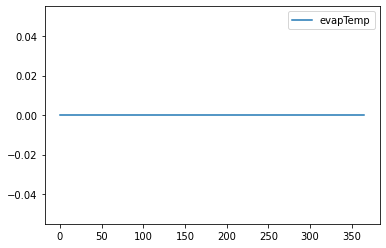

In [ ]:
plt.plot(data["evapTemp"][0,0,:], label="evapTemp")
plt.legend()
plt.show()

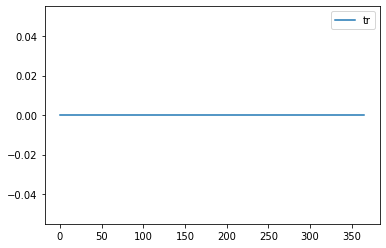

In [ ]:
plt.plot(data["tr"][0,0,:], label="tr")
plt.legend()
plt.show()

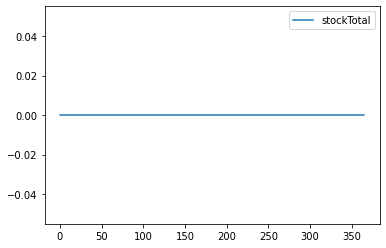

In [ ]:
plt.plot(data["stockTotal"][0,0,:], label="stockTotal")
plt.legend()
plt.show()

In [225]:
def EvalVitesseRacSarraV3(data, paramVariete):

	data["vRac"][data["numPhase"] == 1] = paramVariete["VRacLevee"]
	data["vRac"][data["numPhase"] == 2] = paramVariete["VRacBVP"] 
	data["vRac"][data["numPhase"] == 3] = paramVariete["VRacPSP"] 
	data["vRac"][data["numPhase"] == 4] = paramVariete["VRacRPR"] 
	data["vRac"][data["numPhase"] == 5] = paramVariete["VRacMatu1"] 
	data["vRac"][data["numPhase"] == 6] = paramVariete["VRacMatu2"] 

	return data